# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Gpu'da çalışmak için düzenleme

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cifar10 datasetini modele hazırlama

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 46703376.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Klas isimlerini ve çıkış katmanının sayısı için variables tanımlama

In [4]:
classes = trainset.classes
num_classes = len(classes)

print(classes, "\n")
print(f"{num_classes=}")

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

num_classes=10


Train datasetinde bir kaç görseli inceleyelim

          dog             dog           truck           automobile


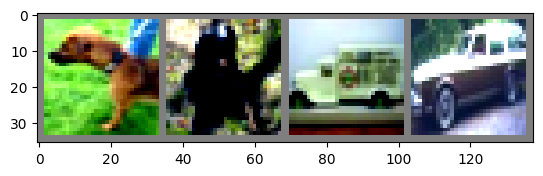

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

print("       " ,"           ".join("%5s" % classes[labels[j]] for j in range(4)))

# Pretrain modelin çağırılması

- Modeli, Imagenet dataseti üzerinde eğitilerek öğrenilmiş ağırlıkları ile beraber çağırıyoruz.
- Bu aşamadan sonra fine-tune işlemi için farklı şekillerde devam edilebilir.
- Modelin bütün parametreleri dondurulur ve modelin sonuna Fully Connection layerlar eklenerek sadece onlar eğitilebilir.
- Modelin son birkaç katmanı eğitim için açılır, diğer katmanları dondurulur.
- Modelin bütün katmanları eğitime açılır.
- Bütün stratejiler için dikkat edilmesi gereken konu yüksek bir Learning Rate kullanmak gradyanların dalgalanmasına sebep olabilir. Bu yüzden düşük LR seçmek önemlidir.

- Bir kaç farklı senaryoyu test edip en iyi senaryoyu tercih ediyorum. Bütün katmanları eğitime açıyorum.

In [6]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


# Modelin Layerlarına bakalım

In [7]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Modeli kendi datasetimize uyarlamalıyız

-  Cifar10 dataları 32*32 pixel; aşırı bilgi kaybı olmaması için ilk conv katmanın kernel_size, stride ve padding parametrelerini tekrar düzenledim.

- Maxpooling katmanı bilgileri sıkıştırdığı için yine aynı sebeple aşırı bilgi kaybından dolayı kaldırdım.

- Fully connection layer'ı cifar10'a uygun hale getirdim.

In [8]:
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

model.maxpool = nn.Identity()

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Düzenlemiş katmanlara tekrar bakalım

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

# Modeli eğitmek için bir func. yazalım

- Her epokta train ve test setleri için loss ve accuracy değerlerini bir dataframe'e kaydediyorum.

In [10]:
def train_model(model, train_loader, test_loader, batch_size: int, epochs: int):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    results_df = pd.DataFrame(columns=["epoch", "train_loss", "test_loss", "test_acc"])

    for epoch in tqdm(range(epochs)):

        running_loss, test_loss = 0.0, 0.0
        for images, labels in train_loader:

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        with torch.no_grad():

            for images, labels in test_loader:

                images, labels  = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

        correct, total = 0, 0
        with torch.no_grad():

            for data in test_loader:

                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch+1} / Train loss: {round(running_loss/len(train_loader), 3)}", end = " ")
        print(f"/ Test loss: {round(test_loss/len(test_loader), 3)}", end = " ")
        print("/ Test Accuracy : % ",   int((100 * correct / total)))

        new_row = pd.DataFrame({"epoch": [epoch+1], "train_loss": [running_loss/len(train_loader)],
                               "test_loss": [test_loss/len(test_loader)], "test_acc" : [int((100 * correct / total))]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    return model, results_df

# 25 epok eğitelim

In [11]:
fine_tune_resnet18, results = train_model(model, trainloader, testloader, batch_size = 32, epochs = 25)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 / Train loss: 2.195 / Test loss: 1.935 / Test Accuracy : %  32
Epoch 2 / Train loss: 1.779 / Test loss: 1.652 / Test Accuracy : %  43
Epoch 3 / Train loss: 1.546 / Test loss: 1.479 / Test Accuracy : %  49
Epoch 4 / Train loss: 1.39 / Test loss: 1.356 / Test Accuracy : %  53
Epoch 5 / Train loss: 1.274 / Test loss: 1.259 / Test Accuracy : %  56
Epoch 6 / Train loss: 1.179 / Test loss: 1.18 / Test Accuracy : %  59
Epoch 7 / Train loss: 1.101 / Test loss: 1.111 / Test Accuracy : %  60
Epoch 8 / Train loss: 1.034 / Test loss: 1.056 / Test Accuracy : %  62
Epoch 9 / Train loss: 0.975 / Test loss: 1.008 / Test Accuracy : %  64
Epoch 10 / Train loss: 0.925 / Test loss: 0.965 / Test Accuracy : %  66
Epoch 11 / Train loss: 0.88 / Test loss: 0.929 / Test Accuracy : %  67
Epoch 12 / Train loss: 0.84 / Test loss: 0.896 / Test Accuracy : %  68
Epoch 13 / Train loss: 0.803 / Test loss: 0.867 / Test Accuracy : %  69
Epoch 14 / Train loss: 0.771 / Test loss: 0.84 / Test Accuracy : %  70
Epoch 

# Sonuçlara bakalım ve plot'layıp inceleyelim

In [21]:
results

,epoch,train_loss,test_loss,test_acc
0,1,2.195216,1.935227,32
1,2,1.778593,1.651626,43
2,3,1.546397,1.478755,49
3,4,1.389949,1.356250,53
4,5,1.273880,1.259012,56
5,6,1.179377,1.179745,59
6,7,1.101126,1.111130,60
7,8,1.033560,1.055531,62
8,9,0.975326,1.008114,64
9,10,0.924992,0.965303,66


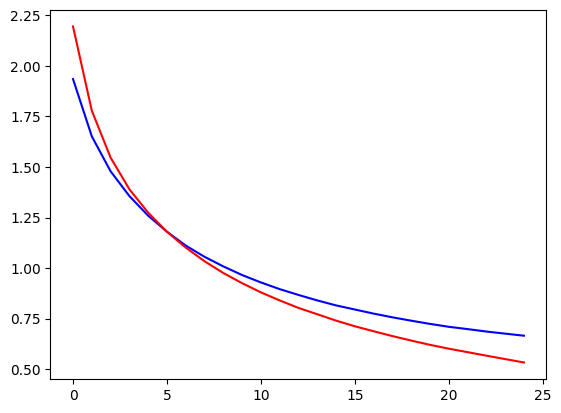

In [19]:
results["test_loss"].plot(color = "b")
results["train_loss"].plot(color = "r");

# Modeli geliştirmek için yapılabilecekler

- Daha uzun eğitim yapılabilir(daha uzun süre eğitildiğinde skorlar iyileşmeye devam ediyor).

- Learning Rate Scheduler kullanırak locale minimum noktalarından kurtularak global minimuma gidilebilir.

- Modelin sonuna katman eklenebilir.

- Conv1 üzerinde değişiklikler yapılabilir.

